In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout
import keras_tuner as kt

figsize = (16,4)
plt.rcParams['figure.figsize'] = figsize
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df = pd.read_parquet("/kaggle/input/stock-history/stock-history-features.parquet")
df.insert(9, "close", df.pop("close"))

In [20]:
df

,stock,day_of_week,day,month,year,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,close
0,TSLA,1,4,1,2022,391.56,11.83,391.56,11.83,383.20
1,TSLA,2,5,1,2022,381.94,18.64,381.94,18.64,362.71
2,TSLA,3,6,1,2022,375.18,20.36,375.18,20.36,354.90
3,TSLA,4,7,1,2022,368.61,22.95,368.61,22.95,342.32
4,TSLA,0,10,1,2022,365.96,21.53,365.96,21.53,352.71
...,...,...,...,...,...,...,...,...,...,...
1876,GOOG,3,27,6,2024,181.86,4.11,179.79,3.64,186.86
1877,GOOG,4,28,6,2024,182.86,3.36,180.34,3.57,183.42
1878,GOOG,0,1,7,2024,183.82,2.49,180.90,3.56,184.49
1879,GOOG,1,2,7,2024,184.73,2.10,181.50,3.77,186.61


## Data Preparation

In [55]:
class StockData:
    def __init__(self, stock, data, look_back=30, test_size=0.2):
        self.stock = stock
        self.data = data.query(f"stock == '{stock}'").copy()
        self.data.drop("stock", axis=1, inplace=True)
        self.look_back = look_back
        self.test_size = test_size
        self.x_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        
        self.X = self.data.values
        self.y = self.data['close'].values.reshape(-1, 1)
        
    def create_sequences(self, data):
        input_data = []
        target_data = []
        for i in range(len(data[0]) - self.look_back):
            input_seq = data[0][i:i+self.look_back]
            input_data.append(input_seq)

            target_value = data[1][i+self.look_back]
            target_data.append(target_value)
        return np.array(input_data), np.array(target_data)
        
    def scale_split_sequence(self):
        X_scaled = self.x_scaler.fit_transform(self.X)
        y_scaled = self.y_scaler.fit_transform(self.y)
        
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, 
                                                            test_size=self.test_size, 
                                                            shuffle=False)
        
        X_train, y_train = self.create_sequences([X_train, y_train])
        X_test, y_test = self.create_sequences([X_test, y_test])
        
        return X_train, X_test, y_train, y_test
    
    def inverse_transform(self, data, scaler='y'):
        scaler_dict = {
            'x': self.x_scaler,
            'y': self.y_scaler
        }
        data_inv = scaler_dict[scaler].inverse_transform(data)
        
        return data_inv

In [ ]:
TSLA = StockData("TSLA", df)
AAPL = StockData("AAPL", df)
GOOG = StockData("GOOG", df)

## Hypermodel

In [21]:
class GRUHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        
        # Hyperparameter settings
        num_gru_layers = hp.Int("num_gru_layers", 1, 3)
        gru_units = [hp.Int(f"gru_units_{i}", min_value=25, max_value=200, step=25) for i in range(num_gru_layers)]
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        
        # Add GRU layers
        for i in range(num_gru_layers):
            model.add(
                GRU(
                    units=gru_units[i],
                    return_sequences=True if i < num_gru_layers - 1 else False,
                    input_shape=(self.look_back, self.input_shape) if i == 0 else None
                )
            )
        
        # Add Output layer
        model.add(Dense(1))

        # Optimizer
        opt = {
            'adam': tf.keras.optimizers.Adam,
            'rmsprop': tf.keras.optimizers.RMSprop,
            'sgd': tf.keras.optimizers.SGD
        }

        # Compile model
        model.compile(
            optimizer=opt[optimizer_choice](learning_rate=learning_rate),
            loss='mse'
        )
        
        return model

## Model Building

In [ ]:
class StockModel:
    def __init__(self, stock_data, hypermodel=None):
        self.stock_data = stock_data
        self.hypermodel = hypermodel if hypermodel else GRUHyperModel()

        self.X_train, self.X_test, self.y_train, self.y_test = self.stock_data.scale_split_sequence()
        self.input_shape = self.X_train.shape[2]
        self.hypermodel.look_back = self.stock_data.look_back
        self.hypermodel.input_shape = self.input_shape

        self.best_model = None

    def train_best_model(self, max_trials=30, epochs=20, validation_split=0.2, monitor='val_loss', patience=5, min_delta=0):
        tuner = kt.RandomSearch(
            self.hypermodel,
            objective='val_loss',
            max_trials=max_trials,
            executions_per_trial=2,
            directory='dir',
            project_name=f'{self.stock_data.stock}'
        )

        stop_early = EarlyStopping(monitor=monitor, min_delta=min_delta, patience=patience)

        tuner.search(self.X_train, self.y_train, epochs=epochs, validation_split=validation_split, callbacks=[stop_early])

        self.best_model = tuner.get_best_models(num_models=1)[0]
        
        return self.best_model

    def evaluate_model(self):
        predictions = self.best_model.predict(self.X_test)
        pred = self.stock_data.inverse_transform(predictions, scaler='y')
        true = self.stock_data.inverse_transform(self.y_test, scaler='y')

        rmse = np.sqrt(mean_squared_error(true, pred))
        print(f"The root mean squared error is {rmse:.2f} USD for {self.stock_data.stock} model.")

        plt.plot(true, label='True')
        plt.plot(pred, label='Predicted')
        plt.title(f"{self.stock_data.stock} Model Performance")
        plt.legend()
        plt.show()

## TSLA

In [23]:
model = StockModel(TSLA, GRUHyperModel())
best_model = model.train_best_model()
best_model.summary()

Reloading Tuner from dir/TSLA/tuner0.json


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 75)         │        19,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 30, 75)         │        34,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 150)            │       102,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,851 (608.79 KB)

 Trainable params: 155,851 (608.79 KB)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
The root mean squared error is 8.25 USD for TSLA model.


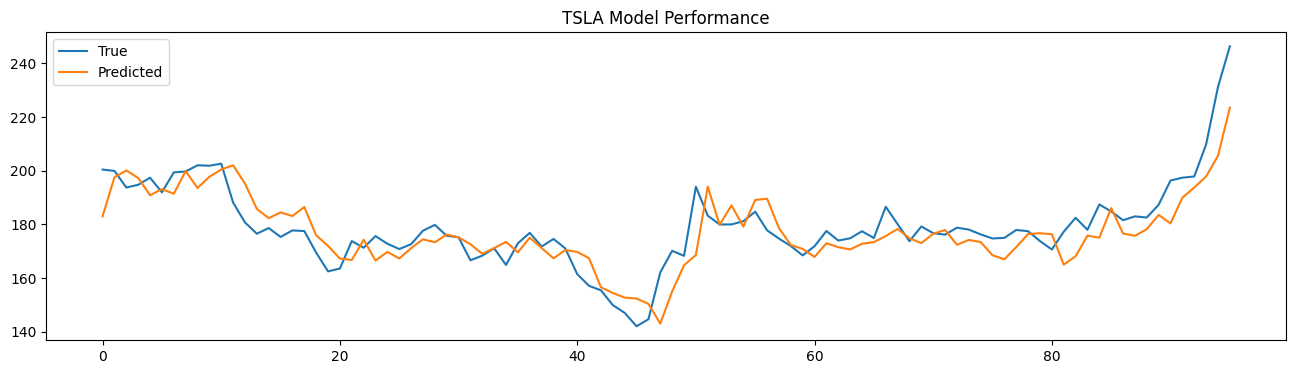

In [7]:
model.evaluate_model()

## AAPL

In [24]:
model = StockModel(AAPL, GRUHyperModel())
model.train_best_model().summary()

Reloading Tuner from dir/AAPL/tuner0.json


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 25)         │         2,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 30, 25)         │         3,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 25)             │         3,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,526 (41.12 KB)

 Trainable params: 10,526 (41.12 KB)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
The root mean squared error is 3.60 USD for AAPL model.


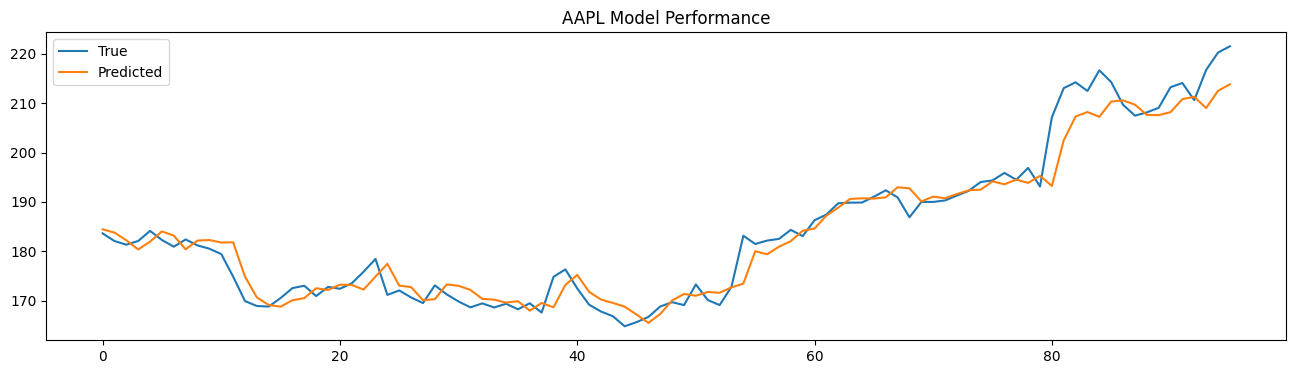

In [17]:
model.evaluate_model()

## GOOG

In [25]:
model = StockModel(GOOG, GRUHyperModel())
model.train_best_model().summary()

Trial 30 Complete [00h 00m 13s]
val_loss: 0.034924549981951714

Best val_loss So Far: 0.0007597169314976782
Total elapsed time: 00h 05m 56s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 200)        │       126,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 175)            │       197,925 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           176 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 324,701 (1.24 MB)

 Trainable params: 324,701 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
The root mean squared error is 3.10 USD for GOOG model.


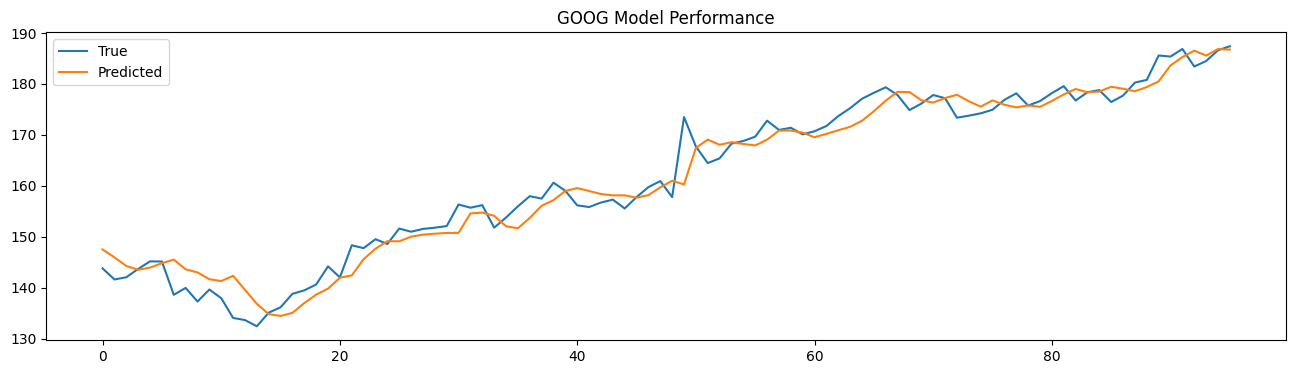

In [26]:
model.evaluate_model()